In [51]:
## pip install lightgbm

In [52]:
## pip install catboost

In [53]:
## pip install ipywidgets

In [54]:
import numpy as np
import pandas as pd
import lightgbm
from lightgbm import LGBMRegressor
import catboost
from catboost import CatBoostRegressor
import sklearn
from sklearn.model_selection import KFold
import IPython
from IPython.display import clear_output
import copy
import matplotlib.pyplot as plt

In [55]:
# import datasets
train = pd.read_csv('../dataset/train.csv')
test = pd.read_csv('../dataset/test.csv')
building = pd.read_csv('../dataset/building_info.csv')
submission = pd.read_csv('../dataset/sample_submission.csv')

In [56]:
display(train)
display(test)

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40
...,...,...,...,...,...,...,...,...,...,...
203995,100_20220824 19,100,20220824 19,23.1,NaN,0.9,86.0,0.5,NaN,881.04
203996,100_20220824 20,100,20220824 20,22.4,NaN,1.3,86.0,0.0,NaN,798.96
203997,100_20220824 21,100,20220824 21,21.3,NaN,1.0,92.0,NaN,NaN,825.12
203998,100_20220824 22,100,20220824 22,21.0,NaN,0.3,94.0,NaN,NaN,640.08


,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%)
0,1_20220825 00,1,20220825 00,23.5,0.0,2.2,72
1,1_20220825 01,1,20220825 01,23.0,0.0,0.9,72
2,1_20220825 02,1,20220825 02,22.7,0.0,1.5,75
3,1_20220825 03,1,20220825 03,22.1,0.0,1.3,78
4,1_20220825 04,1,20220825 04,21.8,0.0,1.0,77
...,...,...,...,...,...,...,...
16795,100_20220831 19,100,20220831 19,22.5,0.0,0.9,84
16796,100_20220831 20,100,20220831 20,20.7,0.0,0.4,95
16797,100_20220831 21,100,20220831 21,20.2,0.0,0.4,98
16798,100_20220831 22,100,20220831 22,20.1,0.0,1.1,97


In [57]:
train_df = train.copy()

train_df = train_df.drop(columns =  ['num_date_time', '일조(hr)', '일사(MJ/m2)', '강수량(mm)'])
train_df = train_df.rename(columns = {'기온(C)':'기온', '풍속(m/s)':'풍속', '습도(%)':'습도', '전력소비량(kWh)':'전력소비량'})
train_df['일시'] = pd.to_datetime(train_df['일시'])
train_df['시간'] = train_df['일시'].dt.hour
train_df['요일'] = train_df['일시'].dt.weekday

holiday = ['2022-06-06', '2022-08-15']
train_df['주말'] = train_df['요일'].isin([5,6]).astype(int)
train_df['공휴일'] = train_df['일시'].isin([5,6]).astype(int)

train_df['휴일'] = train_df['주말'] + train_df['공휴일']


train_df['sin_시간'] = np.sin(2*np.pi*(train_df['시간'])/23)
train_df['cos_시간'] = np.cos(2*np.pi*(train_df['시간'])/23)

train_df = train_df.fillna(0)
train_df = train_df.drop(columns = ['일시', '주말', '공휴일'])

In [58]:
T = 9/5*train_df['기온']
train_df['불쾌지수'] = T - 0.55*(1-train_df['습도']/100)*(T-26)+32
train_df['불쾌지수'] = pd.cut(train_df['불쾌지수'], bins = [0, 68, 75, 80, 200], labels = [1, 2, 3, 4])

(array([22498.,     0.,     0., 59862.,     0.,     0., 80715.,     0.,
            0., 40925.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

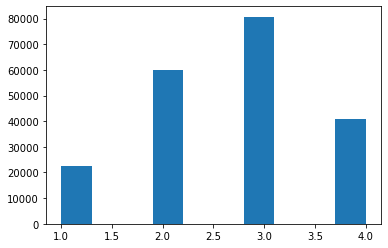

In [59]:
plt.hist(train_df['불쾌지수'])

In [60]:
train_df

,건물번호,기온,풍속,습도,전력소비량,시간,요일,휴일,sin_시간,cos_시간,불쾌지수
0,1,18.6,0.9,42.0,1085.28,0,2,0,0.000000e+00,1.000000,1
1,1,18.0,1.1,45.0,1047.36,1,2,0,2.697968e-01,0.962917,1
2,1,17.7,1.5,45.0,974.88,2,2,0,5.195840e-01,0.854419,1
3,1,16.7,1.4,48.0,953.76,3,2,0,7.308360e-01,0.682553,1
4,1,18.4,2.8,43.0,986.40,4,2,0,8.878852e-01,0.460065,1
...,...,...,...,...,...,...,...,...,...,...,...
203995,100,23.1,0.9,86.0,881.04,19,2,0,-8.878852e-01,0.460065,2
203996,100,22.4,1.3,86.0,798.96,20,2,0,-7.308360e-01,0.682553,2
203997,100,21.3,1.0,92.0,825.12,21,2,0,-5.195840e-01,0.854419,2
203998,100,21.0,0.3,94.0,640.08,22,2,0,-2.697968e-01,0.962917,2


In [61]:
def CDH(x):
    y = []
    for i in range(len(x)):
        if i<11:
            y.append(np.sum(x[:(i+1)]-26))
        else:
            y.append(np.sum(x[(i-11):(i+1)]-26))
    return np.array(x)

In [62]:
cdhs = np.array([])

for num in range(1, 101):
    temp = train_df[train_df['건물번호'] == num]
    cdh = CDH(temp['기온'].values)
    cdhs = np.concatenate([cdhs, cdh])

train_df['CDH'] = cdhs

In [63]:
def detect_outliers(df,ratio): #iqr 이상치제거 
    outlier_indices = [] 
    Q1 = np.percentile(df, 25) 
    Q3 = np.percentile(df, 75) 
    IQR = Q3 - Q1 
    outlier_step = ratio * IQR 
    return ~(df < Q1 - outlier_step) | (df > Q3 + outlier_step)


c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 54413 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 49549 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 49845 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarni

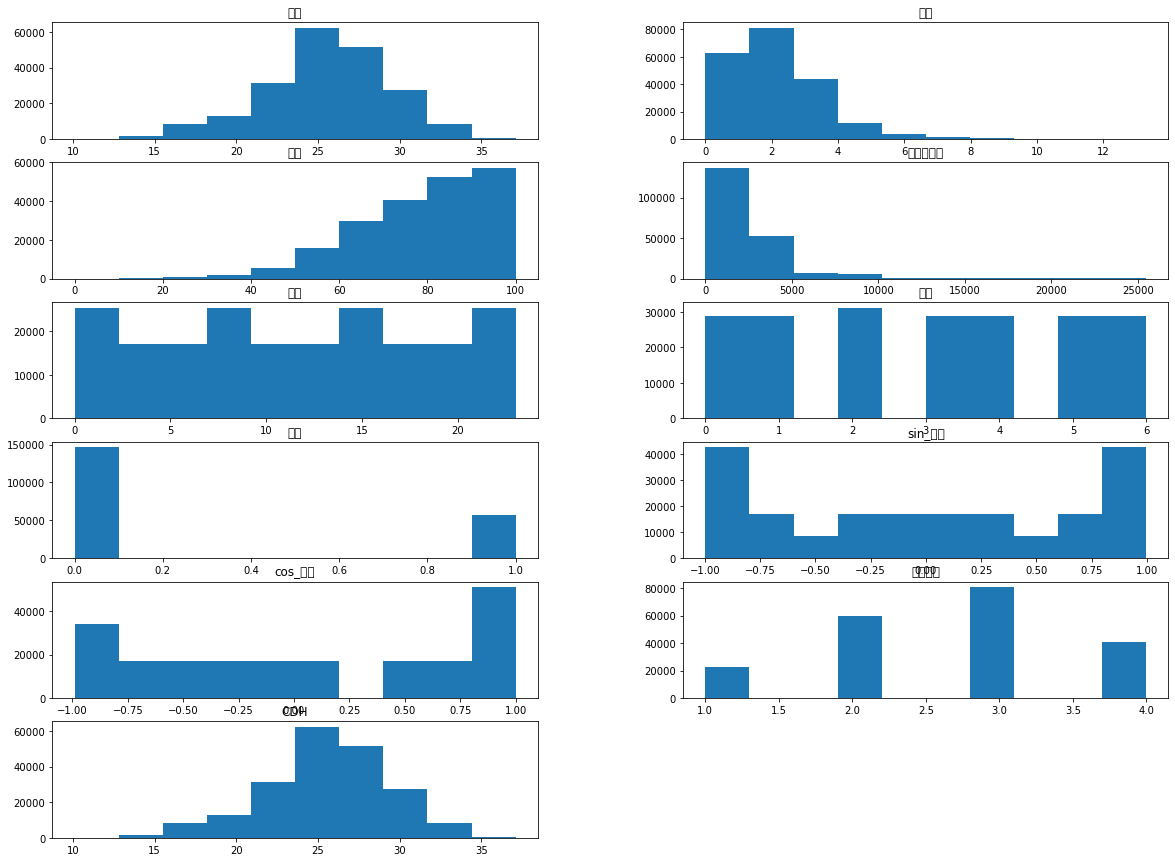

In [64]:
import matplotlib.gridspec as gridspec 

grid = gridspec.GridSpec(6,2)
fig = plt.figure(figsize = (20, 15))
plt.subplots_adjust(wspace = 0.3, hspace = 0.2)

for idx, feature in enumerate(train_df.columns[1:]):
    ax = plt.subplot(grid[idx])
    plt.hist(train_df[feature])
    plt.title(f"{feature}")

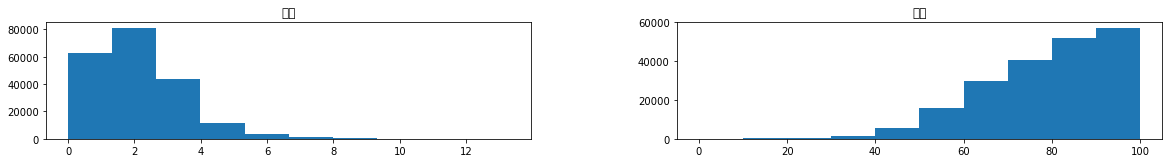

In [65]:
import matplotlib.gridspec as gridspec 

grid = gridspec.GridSpec(6,2)
fig = plt.figure(figsize = (20, 15))
plt.subplots_adjust(wspace = 0.3, hspace = 0.2)

for idx, feature in enumerate(['풍속', '습도']):
    ax = plt.subplot(grid[idx])
    plt.hist(train_df[feature])
    plt.title(f"{feature}")

In [66]:
train_df['풍속'] = np.log1p(train_df['풍속'])
train_df['습도'] = np.log1p(train_df['습도'])

In [67]:
test_df = test.copy()

test_df = test_df.drop(columns =  ['num_date_time', '강수량(mm)'])
test_df = test_df.rename(columns = {'기온(C)':'기온', '풍속(m/s)':'풍속', '습도(%)':'습도'})
test_df['일시'] = pd.to_datetime(test_df['일시'])
test_df['시간'] = test_df['일시'].dt.hour
test_df['요일'] = test_df['일시'].dt.weekday
test_df['휴일'] = test_df['요일'].isin([5,6]).astype(int)
test_df = test_df.fillna(0)
test_df = test_df.drop(columns = '일시')

T = 9/5*test_df['기온']
test_df['불쾌지수'] = T - 0.55*(1-test_df['습도']/100)*(T-26)+32
test_df['불쾌지수'] = pd.cut(test_df['불쾌지수'], bins = [0, 68, 75, 80, 200], labels = [1, 2, 3, 4])

cdhs = np.array([])
for num in range(1, 101):
    temp = test_df[test_df['건물번호'] == num]
    cdh = CDH(temp['기온'].values)
    cdhs = np.concatenate([cdhs, cdh])

test_df['CDH'] = cdhs

test_df['풍속'] = np.log1p(test_df['풍속'])
test_df['습도'] = np.log1p(test_df['습도'])

test_df['sin_시간'] = np.sin(2*np.pi*(test_df['시간'])/23)
test_df['cos_시간'] = np.cos(2*np.pi*(test_df['시간'])/23)

test_df = test_df[['건물번호', '기온', '풍속', '습도', '시간', '요일', '휴일', '불쾌지수', 'CDH']]
test_dfs  = []
for i in range(1,101):
    test_dfs.append(test_df[test_df['건물번호']==i])

test_df 


,건물번호,기온,풍속,습도,시간,요일,휴일,불쾌지수,CDH
0,1,23.5,1.163151,4.290459,0,3,0,2,23.5
1,1,23.0,0.641854,4.290459,1,3,0,2,23.0
2,1,22.7,0.916291,4.330733,2,3,0,2,22.7
3,1,22.1,0.832909,4.369448,3,3,0,2,22.1
4,1,21.8,0.693147,4.356709,4,3,0,2,21.8
...,...,...,...,...,...,...,...,...,...
16795,100,22.5,0.641854,4.442651,19,2,0,2,22.5
16796,100,20.7,0.336472,4.564348,20,2,0,2,20.7
16797,100,20.2,0.336472,4.595120,21,2,0,2,20.2
16798,100,20.1,0.741937,4.584967,22,2,0,2,20.1


c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 44148 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 47932 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 48264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 54840 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarni

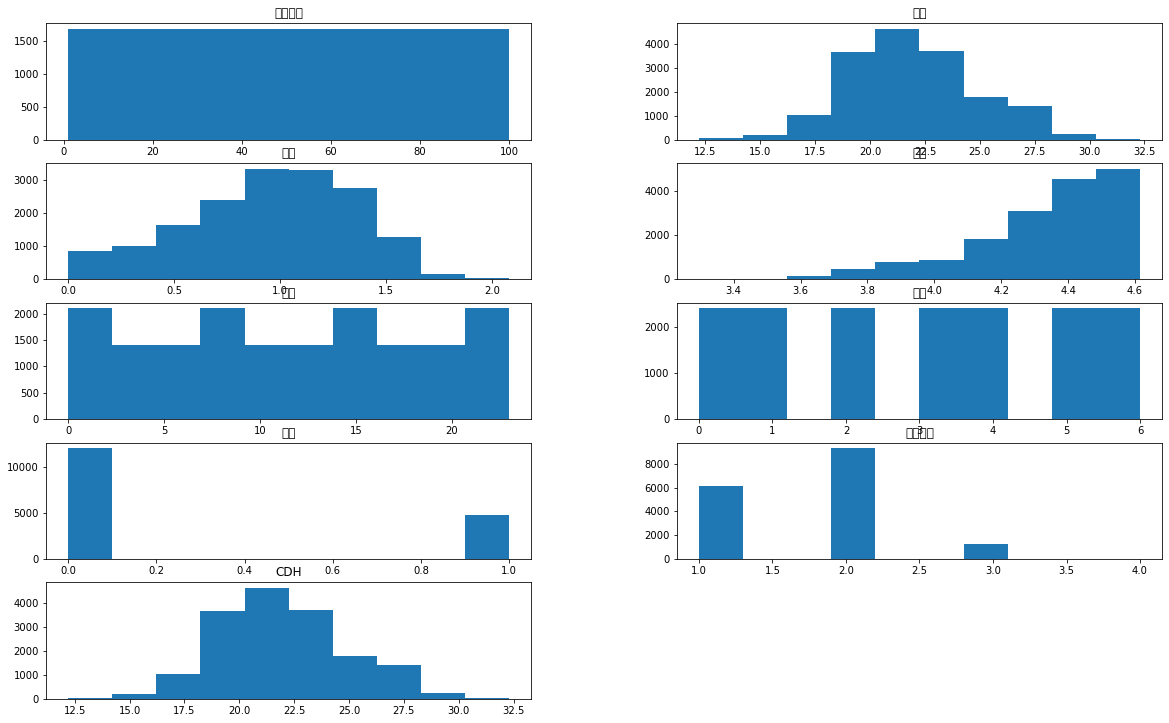

In [68]:
import matplotlib.gridspec as gridspec 

grid = gridspec.GridSpec(6,2)
fig = plt.figure(figsize = (20, 15))
plt.subplots_adjust(wspace = 0.3, hspace = 0.2)

for idx, feature in enumerate(test_df.columns):
    ax = plt.subplot(grid[idx])
    plt.hist(test_df[feature])
    plt.title(f"{feature}")

In [69]:
train_df = train_df[['전력소비량', '건물번호', '기온', '풍속', '습도', '시간', '요일', '휴일', '불쾌지수', 'CDH']]

train_dfs  = []
for i in range(1,101):
    train_dfs.append(train_df[train_df['건물번호']==i]) 

In [70]:
train_input = [] 
train_target = []

for i in range(len(train_dfs)):
    train_input.append(copy.deepcopy(train_dfs[i][train_dfs[i].columns[1:]])) 
    train_target.append(copy.deepcopy(train_dfs[i][train_dfs[i].columns[0]]))

In [71]:
# 이상치처리
for i in range(60):    
    idx = detect_outliers(train_target[i],1.25)
    train_target[i] = train_target[i][idx]
    train_input[i] = train_input[i][idx]

In [72]:
train_input[0]

,건물번호,기온,풍속,습도,시간,요일,휴일,불쾌지수,CDH
0,1,18.6,0.641854,3.761200,0,2,0,1,18.6
1,1,18.0,0.741937,3.828641,1,2,0,1,18.0
2,1,17.7,0.916291,3.828641,2,2,0,1,17.7
3,1,16.7,0.875469,3.891820,3,2,0,1,16.7
4,1,18.4,1.335001,3.784190,4,2,0,1,18.4
...,...,...,...,...,...,...,...,...,...
2035,1,25.5,1.360977,4.158883,19,2,0,2,25.5
2036,1,25.0,1.280934,4.204693,20,2,0,2,25.0
2037,1,24.6,0.832909,4.219508,21,2,0,2,24.6
2038,1,24.1,1.131402,4.262680,22,2,0,2,24.1


In [73]:
K = [i for i in [5, 8, 10]]
random_seed = 42

for k in K: # kfold 의 nspilt 의 값 k
    folds = []
    for i in range(len(train_dfs)):
        cross = KFold(n_splits = k, shuffle = True, random_state = random_seed)
        fold = []
        for train_idx, valid_idx in cross.split(train_input[i], train_target[i]):
            fold.append((train_idx, valid_idx))
        folds.append(fold)

In [74]:
print(folds)

[[(array([   0,    1,    2, ..., 2037, 2038, 2039]), array([  29,   56,   65,   69,   70,   99,  100,  109,  111,  115,  120,
        124,  128,  135,  210,  211,  212,  233,  239,  251,  254,  256,
        270,  289,  297,  298,  299,  306,  307,  324,  344,  350,  352,
        366,  367,  374,  393,  394,  411,  414,  416,  422,  450,  464,
        480,  483,  485,  495,  507,  519,  529,  534,  543,  548,  552,
        554,  561,  572,  585,  593,  596,  599,  602,  607,  613,  618,
        619,  674,  678,  680,  705,  706,  730,  736,  741,  743,  757,
        759,  767,  771,  780,  787,  802,  818,  829,  873,  879,  888,
        900,  903,  915,  922,  940,  964,  966,  968,  979,  982,  984,
        986,  990, 1000, 1001, 1009, 1022, 1023, 1052, 1063, 1068, 1085,
       1087, 1094, 1106, 1107, 1112, 1118, 1125, 1151, 1164, 1175, 1176,
       1185, 1196, 1211, 1247, 1249, 1258, 1263, 1268, 1285, 1286, 1299,
       1315, 1316, 1344, 1362, 1364, 1375, 1391, 1406, 1418, 1421, 1422

In [75]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype   
---  ------  --------------   -----   
 0   전력소비량   204000 non-null  float64 
 1   건물번호    204000 non-null  int64   
 2   기온      204000 non-null  float64 
 3   풍속      204000 non-null  float64 
 4   습도      204000 non-null  float64 
 5   시간      204000 non-null  int64   
 6   요일      204000 non-null  int64   
 7   휴일      204000 non-null  int32   
 8   불쾌지수    204000 non-null  category
 9   CDH     204000 non-null  float64 
dtypes: category(1), float64(5), int32(1), int64(3)
memory usage: 13.4 MB


In [76]:
train_df

,전력소비량,건물번호,기온,풍속,습도,시간,요일,휴일,불쾌지수,CDH
0,1085.28,1,18.6,0.641854,3.761200,0,2,0,1,18.6
1,1047.36,1,18.0,0.741937,3.828641,1,2,0,1,18.0
2,974.88,1,17.7,0.916291,3.828641,2,2,0,1,17.7
3,953.76,1,16.7,0.875469,3.891820,3,2,0,1,16.7
4,986.40,1,18.4,1.335001,3.784190,4,2,0,1,18.4
...,...,...,...,...,...,...,...,...,...,...
203995,881.04,100,23.1,0.641854,4.465908,19,2,0,2,23.1
203996,798.96,100,22.4,0.832909,4.465908,20,2,0,2,22.4
203997,825.12,100,21.3,0.693147,4.532599,21,2,0,2,21.3
203998,640.08,100,21.0,0.262364,4.553877,22,2,0,2,21.0


In [77]:
train_input[0]

,건물번호,기온,풍속,습도,시간,요일,휴일,불쾌지수,CDH
0,1,18.6,0.641854,3.761200,0,2,0,1,18.6
1,1,18.0,0.741937,3.828641,1,2,0,1,18.0
2,1,17.7,0.916291,3.828641,2,2,0,1,17.7
3,1,16.7,0.875469,3.891820,3,2,0,1,16.7
4,1,18.4,1.335001,3.784190,4,2,0,1,18.4
...,...,...,...,...,...,...,...,...,...
2035,1,25.5,1.360977,4.158883,19,2,0,2,25.5
2036,1,25.0,1.280934,4.204693,20,2,0,2,25.0
2037,1,24.6,0.832909,4.219508,21,2,0,2,24.6
2038,1,24.1,1.131402,4.262680,22,2,0,2,24.1


In [79]:
random_seed = 42
K = [i for i in [5, 8, 10]]
catfeatures = ['요일', '휴일', '불쾌지수']

cat_mae_params = {
    'objective': 'MAE',
    'n_estimators': 10000,
    'early_stopping_rounds': 4, 
    'cat_features' : catfeatures,
    'one_hot_max_size' : 7
} # catboost hyper parameter

lgbm_mae_params = {
    'objective': 'MAE',
    'boosting_type': 'goss',
    'n_estimators': 10000,
    'early_stopping_round': 15, 
    'num_leaves':39,
    'categorical_feature = name' : catfeatures
} # lightgbm hyper parameter


for k in K: # kfold 의 nspilt 의 값 k
    folds = []
    for i in range(len(train_dfs)):
        cross = KFold(n_splits = k, shuffle = True, random_state = random_seed)
        fold = []
        for train_idx, valid_idx in cross.split(train_input[i], train_target[i]):
            fold.append((train_idx, valid_idx))
        folds.append(fold)
            
    for i in range(len(train_dfs)):
        for fold in range(k):
            print(random_seed, k, i)
            train_idx, valid_idx = folds[i][fold]
            X_train = train_input[i].iloc[train_idx]
            y_train = train_target[i].iloc[train_idx]
            X_valid = train_input[i].iloc[valid_idx]
            y_valid = train_target[i].iloc[valid_idx]                
            # catboost 학습 
            model = CatBoostRegressor(**cat_mae_params)
            model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
            v = model.predict(test_dfs[i][train_input[i].columns]) * 0.3
                
            #lgbm 학습 
            model=LGBMRegressor(**lgbm_mae_params)
            model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])        
            v += model.predict(test_dfs[i][train_input[i].columns]) * 0.7
                
            submission['answer'].iloc[(i)*168:(i+1)*168] += v/(len(K)*k)
            clear_output(True)   

submission.to_csv('../submission/answer5.csv', index = False) # 파일 저장

42 10 99
0:	learn: 264.9960140	test: 258.2341047	best: 258.2341047 (0)	total: 2.19ms	remaining: 21.9s
1:	learn: 257.3575925	test: 250.9145333	best: 250.9145333 (1)	total: 4.36ms	remaining: 21.8s
2:	learn: 250.1260093	test: 243.8291196	best: 243.8291196 (2)	total: 6.36ms	remaining: 21.2s
3:	learn: 243.1957217	test: 237.1824770	best: 237.1824770 (3)	total: 8.25ms	remaining: 20.6s
4:	learn: 236.2789737	test: 230.7685269	best: 230.7685269 (4)	total: 10.3ms	remaining: 20.6s
5:	learn: 229.7612824	test: 224.7204289	best: 224.7204289 (5)	total: 12.3ms	remaining: 20.4s
6:	learn: 223.3377837	test: 218.5822568	best: 218.5822568 (6)	total: 14.4ms	remaining: 20.5s
7:	learn: 217.0331862	test: 212.4603763	best: 212.4603763 (7)	total: 17.2ms	remaining: 21.5s
8:	learn: 211.0659809	test: 206.7772308	best: 206.7772308 (8)	total: 20.4ms	remaining: 22.6s
9:	learn: 205.1740240	test: 201.2267136	best: 201.2267136 (9)	total: 22.4ms	remaining: 22.4s
10:	learn: 199.7582678	test: 196.2633710	best: 196.2633710 (1

In [80]:
submission

,num_date_time,answer
0,1_20220825 00,1722.915252
1,1_20220825 01,1573.695811
2,1_20220825 02,1549.643919
3,1_20220825 03,1238.310258
4,1_20220825 04,1203.219859
...,...,...
16795,100_20220831 19,857.693856
16796,100_20220831 20,783.028554
16797,100_20220831 21,680.564666
16798,100_20220831 22,595.423069


In [81]:
best = pd.read_csv('../submission/answer3.csv')
update = pd.read_csv('../submission/answer5.csv')

In [86]:
best

,num_date_time,answer
0,1_20220825 00,2272.792389
1,1_20220825 01,2076.237882
2,1_20220825 02,2056.240671
3,1_20220825 03,1617.393980
4,1_20220825 04,1586.417989
...,...,...
16795,100_20220831 19,855.286478
16796,100_20220831 20,781.568550
16797,100_20220831 21,682.149608
16798,100_20220831 22,596.536608


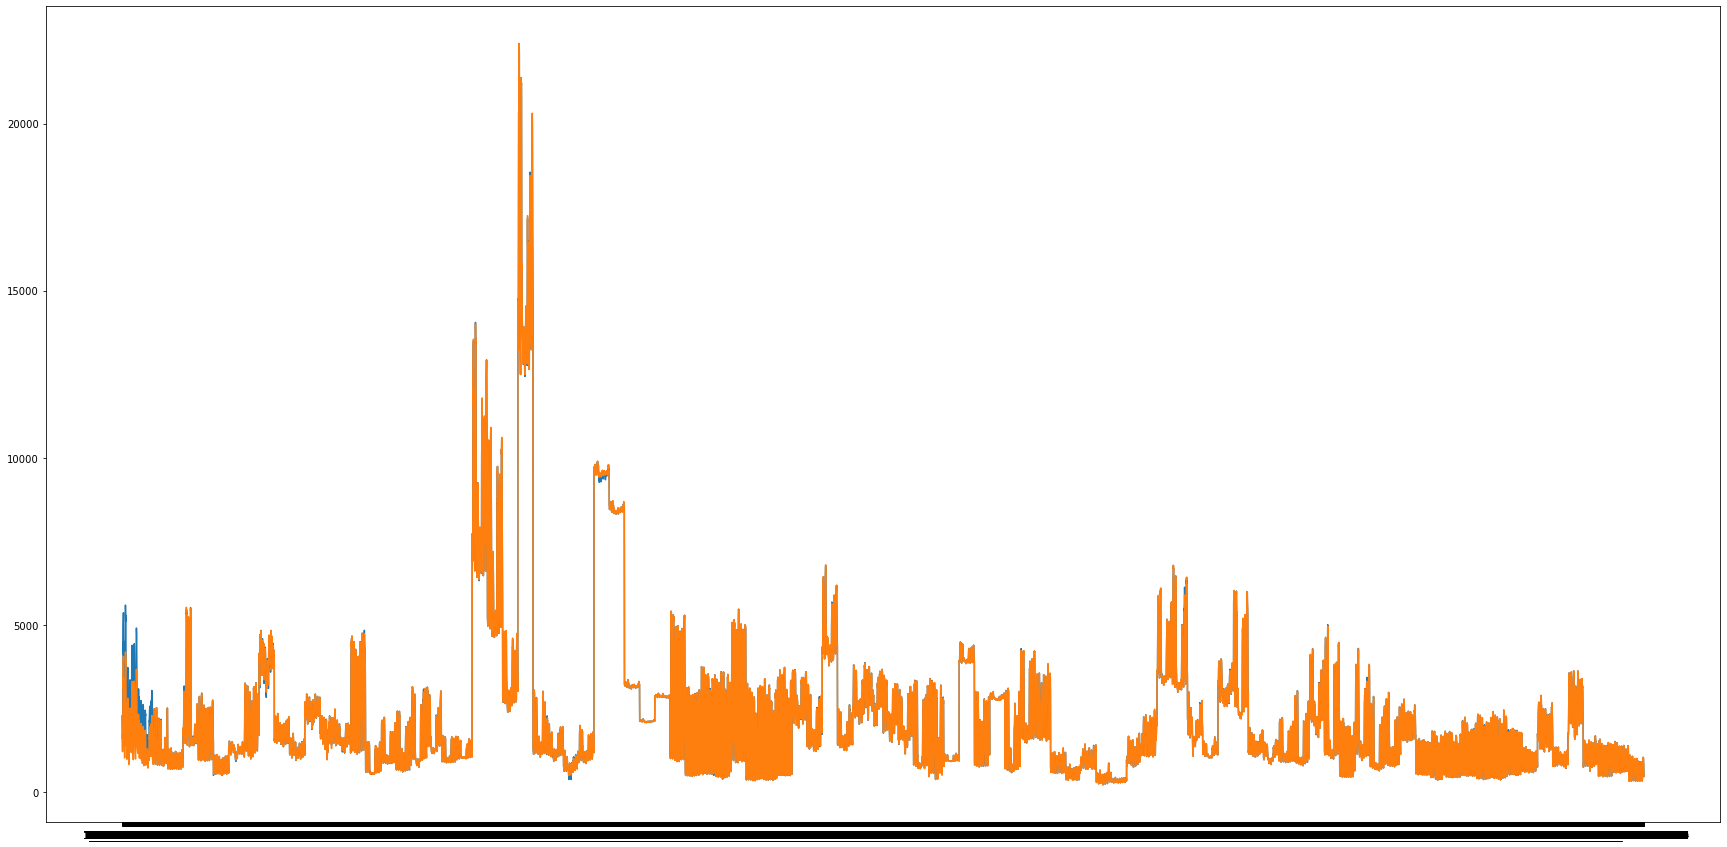

In [94]:
x = np.array(best['num_date_time'])
y = np.array(best['answer'])

x_ = np.array(update['num_date_time'])
y_ = np.array(update['answer'])

plt.figure(figsize = (30, 15))
plt.plot(x, y)
plt.plot(x_, y_)